In [1]:
import urllib.request
import pandas as pd
from osgeo import gdal, osr


import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
import shapefile


from bokeh.plotting import figure, save
from bokeh.models import ColumnDataSource, HoverTool, LogColorMapper
import geopandas as gpd
import pysal as ps


from PIL import Image, ImageFilter
import cv2
import datetime
from datetime import timedelta



/home/lucas/anaconda3/envs/teste/lib/python3.6/site-packages/pysal/__init__.py:65: VisibleDeprecationWarning: PySAL's API will be changed on 2018-12-31. The last release made with this API is version 1.14.4. A preview of the next API version is provided in the `pysal` 2.0 prelease candidate. The API changes and a guide on how to change imports is provided at https://migrating.pysal.org
  ), VisibleDeprecationWarning)


In [82]:
#RAIOS
from pykml import parser
import numpy as np

with open('radar_img/linet_0-15.kml') as f:
    folder = parser.parse(f).getroot().Document
coordList=[]
for pm in folder.Placemark:
    rawCoord = pm.Point.coordinates    
    coord = str(rawCoord).split(",")
    coordList.append(coord)
    
coordArray = np.array(coordList, dtype=float)
#Fazer Array de Lat e Lon, separado porimport os


['BRA', 'Brazil', 'BRA.25_1', 'São Paulo', '', '', 'Estado', 'State', '', 'BR.SP']


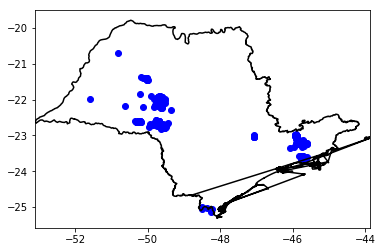

In [85]:
import os
from osgeo import ogr
import shapefile
import numpy as np
import matplotlib.pyplot as plt


from shapely.geometry import Point
from shapely.geometry.polygon import Polygon


daShapefile = 'gadm/gadm36_BRA_1.shp'
sf = shapefile.Reader(daShapefile)
shapes = sf.shapes()
fields = sf.fields
record = sf.records()

i = 24
shape_ex = sf.shape(i).points
print (sf.record(i))

for x, y in coordArray:
    #print (x,y)
    point = Point(x, y)
    polygon = Polygon(shape_ex)
    if polygon.contains(point):
        #print(point)
        plt.plot(x,y,'bo')

x_lon = np.zeros((len(shape_ex),1))
y_lat = np.zeros((len(shape_ex),1))

for ip in range(len(shape_ex)):
    x_lon[ip] = shape_ex[ip][0]
    y_lat[ip] = shape_ex[ip][1]
plt.plot(x_lon,y_lat,'k')

plt.xlim(sf.shape(i).bbox[0],sf.shape(i).bbox[2])
plt.show()


GID_0: BRA
NAME_0:Country name eg: Brazil
GID_1: BRA.1_1
NAME_1: Estate name (eg: São Paulo)
VARNAME_1: ''
NL_NAME_1: ''
NAME2: Campinas
VARNAME_2: ''
NL_NAME_2: ''
TYPE_1: Estado
ENGTYPE_1: State
CC_1: ''
HASC_1: BR.AC

dataSource = ogr.Open(daShapefile)
daLayer = dataSource.GetLayer(0)
layerDefinition = daLayer.GetLayerDefn()
feature = daLayer.GetNextFeature()
while feature:
    print(feature)
    # do something here
    feature = daLayer.GetNextFeature()
daLayer.ResetReading()


for i in range(layerDefinition.GetFieldCount()):
    fieldName =  layerDefinition.GetFieldDefn(i).GetName()
    fieldTypeCode = layerDefinition.GetFieldDefn(i).GetType()
    fieldType = layerDefinition.GetFieldDefn(i).GetFieldTypeName(fieldTypeCode)
    fieldWidth = layerDefinition.GetFieldDefn(i).GetWidth()
    GetPrecision = layerDefinition.GetFieldDefn(i).GetPrecision()

    print (fieldName + " - " + fieldType+ " " + str(fieldWidth) + " " + str(GetPrecision))

PLOT DO MAPA DE SAO PAULO COM SHAPEFILE DOS MUNICIPIOS

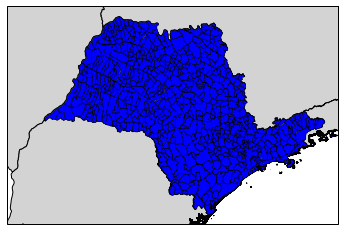

In [18]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
import shapefile

fname = 'gadm/gadm36_BRA_2.shp'
fname2 = 'gadm/gadm36_BRA_1.shp'

ax = plt.axes(projection=ccrs.Robinson())
ax.set_extent([-54, -44, -25.5, -19.5])

sf = Reader(fname)
ax.add_geometries(Reader(fname2).geometries(), ccrs.PlateCarree()
                  ,facecolor='lightgray', edgecolor='black', linewidth=1)


# construction of a dctionary field_name:value  
for record, geometry in zip(sf.records(), sf.geometries()):
    if record.attributes['NAME_1'] == 'São Paulo':
        cor = 'b'
        ax.add_geometries([geometry], ccrs.PlateCarree(),
                          facecolor=cor, edgecolor='black', linewidth=0.5)
        
plt.show()

DOWNLOAD DE IMAGEM DE RADAR DO IPMET

In [4]:
minuto = ['00', '15', '30', '45']
segundo = '00'
now = datetime.datetime.utcnow() - timedelta(hours=3)

#IPMET
url_ipmet = "https://www.ipmet.unesp.br/restrito/imagens_radar/ppi_int/"
for m in minuto[::-1]:
    try:
        last_ipmet = now.strftime("%y%m%d%H."+str(m+"A"))
        urllib.request.urlretrieve(url_ipmet+last_ipmet, "radar_img/last_ipmet.gif")
        urllib.request.urlretrieve(url_ipmet+last_ipmet, now_utc.strftime('radar_img/%H%M.gif'))
        print (url_ipmet+last_ipmet)
        break
    except:
        pass

CONVERÇAO DE IMAGEM PRA POSICAO

(494, 588, 3)
(494, 588, 3)


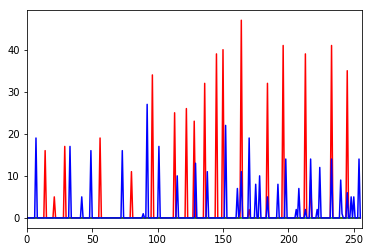

In [101]:
img = Image.open('radar_img/last_ipmet.gif',)
img.save("radar_img/last_ipmet.tiff",'tiff', optimize=True, quality=100)

src_filename ='radar_img/last_ipmet.tiff' 
dst_filename = 'radar_img/dest.tiff'

img4=np.array(img.convert('RGB'))
print(img4.shape)
img2 = cv2.imread(src_filename)
print (img2.shape)
img5=img2-img4

img3 = cv2.imread('radar_img/last_ipmet.gif')
color=('r', 'g', 'b')
for i, col in enumerate(color):
    hist = cv2.calcHist([img5],[i],None,[256],[110,256])
    plt.plot(hist,color=col)
    plt.xlim([0,256])
plt.show()

# Opens source dataset
src_ds = gdal.Open(src_filename)
print(src_ds.GetProjection())
format = "GTiff"
driver = gdal.GetDriverByName(format)

# Open destination dataset
dst_ds = driver.CreateCopy(dst_filename, src_ds, 0)

# Specify raster location through geotransform array
# (uperleftx, scalex, skewx, uperlefty, skewy, scaley)
# Scale = size of one pixel in units of raster projection
# this example below assumes 100x100
gt = [-7916400, 100, 0, 5210940, 0, -100]

# Set location
dst_ds.SetGeoTransform(gt)

# Get raster projection
epsg = 3857
srs = osr.SpatialReference()
srs.ImportFromEPSG(epsg)
dest_wkt = srs.ExportToWkt()

# Set projection
dst_ds.SetProjection(dest_wkt)

# Close files
dst_ds = None
src_ds = None
#image1 = cv2.imread("local.gif")
#cv2.imshow('image',image1)
#Redemet
#tamanho da imagem. px
#Tamanho da imagem. km
#Posiçao do Centro. lat/lon
# 1km = 0.008 lat
# (n km/40000) * 360
#Criar quadrado com 500km de largura = PosX e Y da imagem




#image3 = image1 - image2j

#NAME_1 = Estado
#NAME_2 = Cidade

DOWNLOAD DE IMAGEM DE RADAR DO REDEMET

In [81]:

now_utc = datetime.datetime.utcnow()
utc_ano = now_utc.strftime("%Y")
utc_mes = now_utc.strftime("%m")
utc_dia = now_utc.strftime("%d")
url_redemet = "https://www.redemet.aer.mil.br/radar/"+utc_ano+"/"+utc_mes+"/"+utc_dia+"/sr/maxcappi/maps/"
print (now_utc)
print (url_redemet)
flag = 0
for h in range(now_utc.hour, now_utc.hour-2, -1):
    for m in range(56, 6 , -10):
        for s in range (15,10,-1):
            if (flag == 0):
                try:
                    last_redemet = now_utc.strftime("%Y-%m-%d--")+str(h).zfill(2)+":"+str(m).zfill(2)+":"+str(s).zfill(2)+".png"
                    urllib.request.urlretrieve(url_redemet+last_redemet, 'radar_img/last_redemet.png')
                    urllib.request.urlretrieve(url_redemet+last_redemet, now_utc.strftime('radar_img/'+str(h).zfill(2)+str(m).zfill(2)+'.png'))
                    flag = 1
                    print (last_redemet)
                    break
                except:
                    pass

colourImg = Image.open("radar_img/last_redemet.png")


2018-12-14 04:36:23.883487
https://www.redemet.aer.mil.br/radar/2018/12/14/sr/maxcappi/maps/
2018-12-14--04:26:12.png
